In [25]:
# Import the relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, \
recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
from sklearn.feature_selection import RFECV

from sportsipy.ncaab.boxscore import Boxscore
from sportsipy.ncaab.boxscore import Boxscores 
from datetime import datetime as date

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Import functions notebook and load data set here
import sys
sys.path.append("../")
from function_notebook_1 import *

In [4]:
df = pd.read_csv('../data/regularseason22.csv').drop(['Unnamed: 0', 'w_loc'], axis = 1)
df2 = pd.read_csv('../data/2022_12_11_games.csv').drop(['Unnamed: 0', 'w_loc'], axis = 1)

In [6]:
df.shape

(1031, 107)

In [7]:
df2.shape

(88, 107)

In [8]:
#train_test_split
X_train = df.drop('fav_win', axis=1)
X_test = df2.drop('fav_win', axis=1)
y_train = df['fav_win']

X_train.shape, X_test.shape

((1031, 106), (88, 106))

In [9]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [10]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

### Logistic Regression

In [11]:
log_feat=feature_select(X_train_scaled,y_train,LogisticRegression,min_features=10)
X_train_best_log = X_train_scaled[log_feat]
X_test_best_log = X_test_scaled[log_feat]

In [12]:
def logreg(X_train, X_test, y_train, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'penalty': ['l1', 'l2' ,'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    
    # Instantiate & fit LogReg model for GridSearch
    grid_logreg = LogisticRegression(random_state=42)
    grid_logreg.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_logreg, param_grid=grid, cv=cv,
                      scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    logreg_params = gs.best_params_
    
    # Use best penalty from best_params
    logreg_penalty = logreg_params['penalty']
    print(f'Penalty: {logreg_penalty}')
    
    # Use best solver from best_params
    logreg_solver = logreg_params['solver']
    print(f'Solver: {logreg_solver}')
    
    # Instantiate & fit LogReg model
    log = LogisticRegression(random_state=42, penalty=logreg_penalty, solver=logreg_solver)
    log.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = log.predict(X_test)
    y_pred_proba = log.predict_proba(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(log, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = log.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
  
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(log, X_train, y_train, name='train', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(log, X_train, y_train)
    
    return y_pred, y_pred_proba

Penalty: l2
Solver: sag
Mean Cross-Val Score: 0.7895408282913559
Train Mean Accuracy: 0.7963142580019399


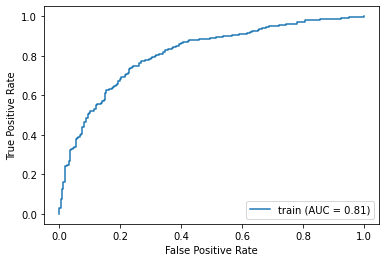

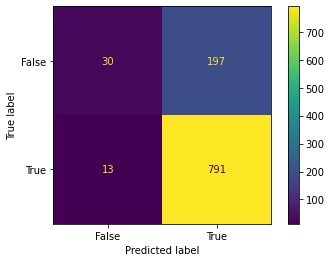

In [13]:
predictions, probabilities = logreg(X_train, X_test, y_train)

In [14]:
predictions

array([False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True])

In [15]:
dog_wins = probabilities[:,0]
dog_wins = dog_wins[dog_wins > .5]
print(dog_wins)

[0.52427719 0.61582776 0.53743102 0.64078054 0.62365366]


In [26]:
games = Boxscores(date.today())
schedule = games.games

In [28]:
game_days = []
for day in schedule.values():
    for game in day:
        game_days.append((game['home_name'], game['away_name']))

In [34]:
dog_winners = []
for i in range(len(predictions)):
    if predictions[i] == False:
        dog_winners.append((game_days[i], probabilities[i][0]))
    

In [35]:
dog_winners

[(('Marquette', 'UCLA'), 0.5242771940080997),
 (('Notre Dame', 'Kentucky'), 0.6158277582895537),
 (('Georgia Tech', 'LSU'), 0.5374310223230376),
 (('Western Carolina', 'UNC Asheville'), 0.640780544572207),
 (('Holy Cross', 'Siena'), 0.623653659021961)]